In [1]:
import pandas as pd
import numpy as np


from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_squared_error, classification_report, root_mean_squared_error, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import svm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestClassifier
import glob

In [120]:
from sklearn.model_selection import GridSearchCV

In [2]:
import seaborn as sns

In [101]:
file_list = glob.glob('/content/*.xlsx')  # Adjust path if necessary
file_list = sorted(file_list)

In [102]:
data=pd.read_excel(file_list[0], engine='openpyxl', sheet_name='Sheet2')

In [103]:
X = data.drop(columns=['hu', 'hg', 'he', 'hp', 'hs', 'hm', 'hi','huL', 'hgL', 'heL', 'hpL', 'hsL', 'hmL', 'hiL', 'Level', 'Binary Level'], axis=1)  # Features
X.columns = X.columns.astype(str)

мультиколлинеарность

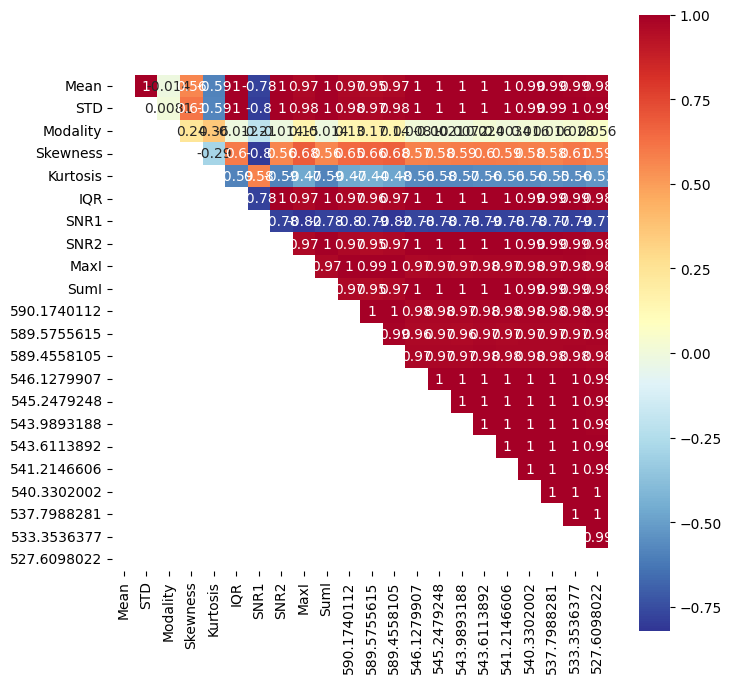

In [104]:
X_corr=X.corr().where(np.triu(np.ones(X.corr().shape), k=1).astype(bool))
plt.figure(figsize=(8, 8))
sns.heatmap(X_corr, cmap="RdYlBu_r", square=True, annot=True);

In [105]:
threshold = 0.95

# Get columns where correlation is greater than threshold
highly_correlated_features = []
for i in range(X.shape[1]):
    for j in range(X.shape[1]):
        #print('i=' + str(i))
        #print('j=' + str(j))
        if abs(X_corr.iloc[i, j]) > threshold:
            # Add only one feature per pair to avoid duplicates and ensure we drop only one feature per pair.
            if X.columns[j] not in highly_correlated_features:
                highly_correlated_features.append(X.columns[i])

# Drop these features from original DataFrame
X_reduced = X.drop(highly_correlated_features, axis=1)

print("Features removed:", highly_correlated_features)
print("Remaining features:", list(X_reduced.columns))

Features removed: ['Mean', 'Mean', 'Mean', 'Mean', 'Mean', 'Mean', 'Mean', 'Mean', 'Mean', 'Mean', 'Mean', 'Mean', 'Mean', 'Mean', 'Mean', 'Mean', 'Mean', 'STD', 'STD', 'STD', 'STD', 'STD', 'STD', 'STD', 'STD', 'STD', 'STD', 'STD', 'STD', 'STD', 'STD', 'STD', 'STD', 'IQR', 'IQR', 'IQR', 'IQR', 'IQR', 'IQR', 'IQR', 'IQR', 'IQR', 'IQR', 'IQR', 'IQR', 'IQR', 'IQR', 'IQR', 'SNR2', 'SNR2', 'SNR2', 'SNR2', 'SNR2', 'SNR2', 'SNR2', 'SNR2', 'SNR2', 'SNR2', 'SNR2', 'SNR2', 'SNR2', 'SNR2', 'MaxI', 'MaxI', 'MaxI', 'MaxI', 'MaxI', 'MaxI', 'MaxI', 'MaxI', 'MaxI', 'MaxI', 'MaxI', 'MaxI', 'MaxI', 'SumI', 'SumI', 'SumI', 'SumI', 'SumI', 'SumI', 'SumI', 'SumI', 'SumI', 'SumI', 'SumI', 'SumI', '590.1740112', '590.1740112', '590.1740112', '590.1740112', '590.1740112', '590.1740112', '590.1740112', '590.1740112', '590.1740112', '590.1740112', '590.1740112', '589.5755615', '589.5755615', '589.5755615', '589.5755615', '589.5755615', '589.5755615', '589.5755615', '589.5755615', '589.5755615', '589.5755615', '

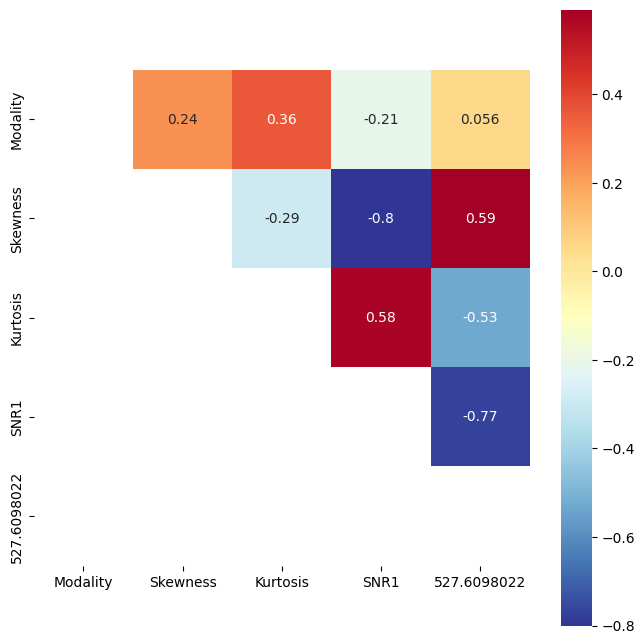

In [106]:
X_new=X_reduced.copy()
X_corr_new=X_new.corr().where(np.triu(np.ones(X_new.corr().shape), k=1).astype(bool))
plt.figure(figsize=(8, 8))
sns.heatmap(X_corr_new, cmap="RdYlBu_r", square=True, annot=True);

Обучение только на экспериментальных данных


In [107]:
#real_data=data.iloc[:25] #Только экспериментальные данные
real_data=data #Экспериментальные и синтетические

In [108]:
shuffled_real_data = real_data.sample(frac=1, random_state=2019).reset_index(drop=True)

In [110]:
X_train, X_test, y_train, y_test=train_test_split(
    shuffled_real_data[X_reduced.columns],
    shuffled_real_data['Binary Level'],
    random_state=2018,
    test_size=0.3
)
#Масштабирование
scaler=StandardScaler()
X_train_scaled=pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled=pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [111]:
y_train.value_counts()

,count
Binary Level,
0,12
1,11


In [112]:
y_test.value_counts()

,count
Binary Level,
0,5
1,5


In [113]:
logreg=LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_preds_logreg=logreg.predict(X_test_scaled)
ac_log=accuracy_score(y_test, y_preds_logreg)
print(f'Accuracy: {ac_log}')
pr_log=precision_score(y_test, y_preds_logreg, zero_division=0)
print(f'Precision: {pr_log}')
rc_log=recall_score(y_test,  y_preds_logreg)
print(f'Recall: {rc_log}')
f1_log=f1_score(y_test,  y_preds_logreg)
print(f'F1: {f1_log}')

Accuracy: 0.7
Precision: 0.6666666666666666
Recall: 0.8
F1: 0.7272727272727273


Другие модели

In [127]:
svm_model = svm.SVC(gamma=1, C=1, kernel='linear')

# Fit the model to training data
svm_model.fit(X_train_scaled, y_train)

# Predict on test data
y_preds_svm = svm_model.predict(X_test_scaled)
# Predict on test data
ac_log=accuracy_score(y_test, y_preds_svm)
print(f'Accuracy: {ac_log}')
pr_log=precision_score(y_test, y_preds_svm, zero_division=0)
print(f'Precision: {pr_log}')
rc_log=recall_score(y_test,  y_preds_svm)
print(f'Recall: {rc_log}')
f1_log=f1_score(y_test,  y_preds_svm)
print(f'F1: {f1_log}')

Accuracy: 0.7
Precision: 0.6666666666666666
Recall: 0.8
F1: 0.7272727272727273


In [131]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [4, 8, 12],        # Maximum depth of trees
    'min_samples_split': [2, 5],   # Min samples to split
    'min_samples_leaf': [1, 2],    # Min samples per leaf
    'max_features': ['sqrt', 'log2']
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42),  # Add random_state for reproducibility
                           param_grid,
                           scoring='f1',       # Or another appropriate scoring metric
                           cv=3,              # Number of cross-validation folds
                           verbose=1)          # Displays progress

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Get the best estimator
best_rfc_model = grid_search.best_estimator_

# Make predictions using the best model
y_preds_rfc = best_rfc_model.predict(X_test_scaled)

# Evaluate
ac_log = accuracy_score(y_test, y_preds_rfc)
print(f'Accuracy: {ac_log}')
pr_log = precision_score(y_test, y_preds_rfc, zero_division=0)
print(f'Precision: {pr_log}')
rc_log = recall_score(y_test, y_preds_rfc)
print(f'Recall: {rc_log}')
f1_log = f1_score(y_test, y_preds_rfc)
print(f'F1: {f1_log}')

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best score: 0.7666666666666666
Accuracy: 0.7
Precision: 0.75
Recall: 0.6
F1: 0.6666666666666666


In [130]:
# Initialize Random Forest classifier
rfc_model = RandomForestClassifier(n_estimators=100)  # Adjust n_estimators as needed

# Fit the model to training data
rfc_model.fit(X_train_scaled, y_train)

# Predict on test data
y_preds_rfc = rfc_model.predict(X_test_scaled)
ac_log=accuracy_score(y_test, y_preds_rfc)
print(f'Accuracy: {ac_log}')
pr_log=precision_score(y_test, y_preds_rfc, zero_division=0)
print(f'Precision: {pr_log}')
rc_log=recall_score(y_test,  y_preds_rfc)
print(f'Recall: {rc_log}')
f1_log=f1_score(y_test,  y_preds_rfc)
print(f'F1: {f1_log}')

Accuracy: 0.6
Precision: 0.6
Recall: 0.6
F1: 0.6


In [133]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],       # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],      # Learning rate
    'max_depth': [3, 4, 5],                 # Max depth of trees
    'min_samples_split': [2, 4],            # Min samples to split
    'min_samples_leaf': [1, 2],             # Min samples per leaf
    'subsample': [0.7, 0.8, 0.9],           # Subsample ratio
    'max_features': ['sqrt', 'log2']       # Max features to consider
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42),  # Add random_state for reproducibility
                           param_grid,
                           scoring='f1',       # Or another appropriate scoring metric
                           cv=3,               # Number of cross-validation folds
                           verbose=1)          # Displays progress

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Get the best estimator
best_gbc_model = grid_search.best_estimator_

# Make predictions using the best model
y_preds_gbc = best_gbc_model.predict(X_test_scaled)

# Evaluate
ac_log = accuracy_score(y_test, y_preds_gbc)
print(f'Accuracy: {ac_log}')
pr_log = precision_score(y_test, y_preds_gbc, zero_division=0)
print(f'Precision: {pr_log}')
rc_log = recall_score(y_test, y_preds_gbc)
print(f'Recall: {rc_log}')
f1_log = f1_score(y_test, y_preds_gbc)
print(f'F1: {f1_log}')

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.7}
Best score: 0.8677248677248678
Accuracy: 0.6
Precision: 0.6
Recall: 0.6
F1: 0.6


In [119]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting classifier
gbc_model = GradientBoostingClassifier(n_estimators=200)  # Adjust n_estimators as needed

# Fit the model to training data
gbc_model.fit(X_train_scaled, y_train)

# Predict on test data
y_preds_gbc = gbc_model.predict(X_test_scaled)
ac_log=accuracy_score(y_test, y_preds_gbc)
print(f'Accuracy: {ac_log}')
pr_log=precision_score(y_test, y_preds_gbc, zero_division=0)
print(f'Precision: {pr_log}')
rc_log=recall_score(y_test,  y_preds_gbc)
print(f'Recall: {rc_log}')
f1_log=f1_score(y_test,  y_preds_gbc)
print(f'F1: {f1_log}')

Accuracy: 0.5
Precision: 0.5
Recall: 0.6
F1: 0.5454545454545454
